In [5]:
# Por si alguien corre en python2
from __future__ import division

# Preparamos todo para correr
import numpy as np
from math import *
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import norm, binom, gamma, poisson, multivariate_normal
from sklearn import linear_model


## Ejercicio 1:Fitteando una recta ruidosa de manera Bayesiana.

Como primer ejemplo de regresión lineal, tratemos de fittear los parametros $a_{0}$, $a_{1}$ de una recta $f(x,\vec{a}) = a_0 + a_{1}x$ donde $x$ está en el intervalo $[-1,1)$.

* **A)** Genere un set artificial de datos usando, usando como valores $a_{1} = 0.5$, $a_{0}= -0.3$. Añada a las mediciones ruido gaussiano  $\epsilon \sim \mathcal{N}(\mu=0, \sigma = 0.2)$. 
Al terminar debería tener un conjunto de $N= 100$  pares $(x_n,t_n)$, con 
$t_n = f(x_n,\vec{a}) + \epsilon$.

* **B)** Como modelo usaremos una regresión lineal de la forma $y(x) = \omega_0 + \omega_1 x$. ¿Cuál base de funciones $\phi_j$ estamos usando? (recuerde que por convención $\phi_0(x)=1$). 
Escriba para estos la matriz de diseño.
$$\Phi = \begin{pmatrix}
\phi_0(x_1) & \phi_1(x_1)\\
\phi_0(x_2) & \phi_1(x_2)\\
\vdots & \vdots)\\
\phi_0(x_N) & \phi_1(x_N)\\
\end{pmatrix}$$

In [6]:
import numpy.random as rr

# Parámetros de la ground truth
a0 = -0.3
a1 = 0.5

beta = 1./1.

# Número de datos
n = 100

# 
x_ = 2 * np.random.rand(n, 1) - 1

# El modelo real (ground truth)
t_ = a0 + a1 * x_

# Agregemos error normal a los datos
#For random samples from N(\mu, \sigma^2), use:
#sigma * np.random.randn(...) + mu
t_ += 0.2*np.random.randn(n, 1)

print(x_.shape, t_.shape)

(100, 1) (100, 1)


In [7]:
x = x_.reshape(len(x_), 1)
t = t_.reshape(len(t_), 1)

# Primero definamos la matriz uniendo dos vectores
phi = np.hstack([x*0.0 + 1, x])
#print(phi)

print(phi.T.shape)
print(phi.shape)

pp = np.dot(phi.T, phi)
pp2 = phi.T @ phi

print('Las dos notaciones para el producto de matrices son idénticas: {}'.format(np.allclose(pp, pp2)))
yy = np.dot(phi.T, t)

print(yy)

(2, 100)
(100, 2)
Las dos notaciones para el producto de matrices son idénticas: True
[[-29.68678687]
 [ 16.87718728]]


In [8]:
wml = np.linalg.solve(pp, yy)
print(wml)
print('a0 = {}'.format(a0))
print('a1 = {}'.format(a1))

[[-0.26421148]
 [ 0.44358694]]
a0 = -0.3
a1 = 0.5


* **C)** Estamos interesados en encontrar los valores de $\omega_0$ y $\omega_1$ de nuestro modelo más probables, dado los datos que tenemos. Estos están dados por el máximo de nuestra distribución posterior. Si usamos priors uniformes en $\omega_0$ y $\omega_1$ para caracterizar nuestro desconocimiento, el máximo del posterior coincide con el de la verosimilitud y es lo que llamamos el *estimador de máxima verosimilitud*. De acuerdo a lo visto en la teórica, dicho valor esta dado por 
$$\begin{pmatrix}
\omega_0^\text{ML}\\
\omega_1^\text{ML}\\
\end{pmatrix} 
= \left(\Phi^T \Phi\right)^{-1}\Phi^T \,\vec{t}
$$
donde recordemos que $\vec{t} = \begin{pmatrix}t_1\\ \vdots \\ t_N\end{pmatrix}$ es el vector de los valores *target* medidos.

Nota: Para un modelo lineal con error gaussiano, este estimador de maxima verosimilitud coincide con lo que se conoce como la solución de *cuadrados mínimos*.

In [9]:
wmlB=np.linalg.inv(pp)@yy
print(wmlB)

[[-0.26421148]
 [ 0.44358694]]


* **D)** Si en vez de utilizar un prior uniforme, utilizamos un prior gaussiano de la forma $p(\vec{\omega}) = \mathcal{N} (\vec{0},\alpha^{-1}{\bf 1})$ (es decir que $p(\vec{\omega}) = p(\omega_0) \times p(\omega_1)$ con cada $p(\omega_i) = \mathcal{N} (\mu=0,\sigma = \alpha)$ ). Calcule la verosimilitud y el posterior (prior*posterior normalizado) al usar solo 1 punto, 2 puntos, 3 puntos y todo el conjunto de 100 puntos.


Si se le complica hacerlo en forma numerica, puede utilizar la formula analitica dle posterior: Como este es un prior conjugado a la gaussiana en la teórica (o en su defecto, en el Bishop ecuacion 3.53), vimos que nuestro posterior es una gaussiana con valor medio
$$
\vec{m}_N = \beta {\bf S}_N \Phi^T \vec{t}\\
{\bf S}_N^{-1} = \alpha {\bf 1} + \beta \Phi^T \Phi
$$
donde $\beta$ es el parámetro de precisión del ruido gaussiano, que se supone conocido. En nuestro caso sería $\beta = (1/\sigma)^2 = (1/0.2)^2 = 25$. Para seleccionar la cantidad de puntos a considerar, puede usar slicing en $\vec{t}$ ( ``t[:N_puntos]``) y en $\Phi$ (``Phi[:N_puntos,:]``).

# Ejercicio 1 bis: Scikit-learn

Scikit-learn es una librería de machine learning con gran soporte para una multitud de algoritmos de análisis de datos, que nos permite acceder a ellos de una forma muy similar, obviando las diferencias técnicas entre sus implementaciones. En la práctica, nadie escribe sus propias funciones para algoritmos (a menos que sea un algoritmo novedoso que estás diseñando), sino que utilizamos las implementaciones provistas por este u otro paquete.

* **A)** Scikit-learn provee una clase LinearRegressor la cual permite obtener las soluciones de cuadrados mínimos en problemas lineales. Importe el paquete, y examine las distintas funciones leyendo la documentación provista en el paquete. Si no es suficiente, [visite la documentación on-line](https://scikit-learn.org/), para familiarizarse con como se utiliza.

In [10]:
def ajuste_lineal(X_train, Y_train, X_test):

    """Calcula un ajuste lineal.

    Input:
    X_train -- datos de entrenamiento, shape=(N,1)
    Y_train -- etiquetas de entrenamiento, shape=(N,1)
    X_test  -- datos de testeo, shape=(N_test,1)

    Output:
    Y_test  -- prediccion de etiquetas para X_test, shape=(N_test,1)
    """

    N=len(X_train)
    N_test=len(X_test)
    #Start
    x = X_train.reshape(len(X_train), 1)
    t = Y_train.reshape(len(Y_train), 1)

    phi = np.hstack([x*0.0 + 1, x])
    pp = np.dot(phi.T, phi)
    yy = np.dot(phi.T, t)

    wml = np.linalg.solve(pp, yy)

    X_test = X_test.reshape(len(X_test), 1)
    phi_test = np.hstack([X_test*0.0 + 1, X_test]) 

    #ahora guardamos los resultados en esta variable
    Y_test = phi_test @ wml
    #Finish
    assert len(Y_test) == len(X_test), "Tamaño de Y_test distinto al de X_test"
    return np.array(Y_test)

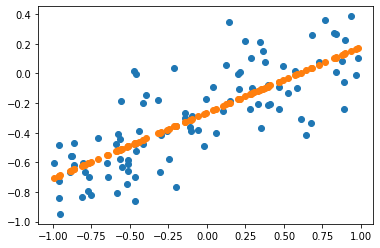

In [11]:
yyy = ajuste_lineal(x_, t_, x)
plt.plot(x_,t_,'o')
plt.plot(x_,yyy,'o')

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
#descomente cada linea para ver la documentación.
#LinearRegression?
#reg.fit?
#reg.predict?
#reg.score?

* **B)** Utilizando los datos del ejercicio anterior, repita el inciso **C)** utilizando scikit-learn.

parametros [[0.44358694]] [-0.26421148]


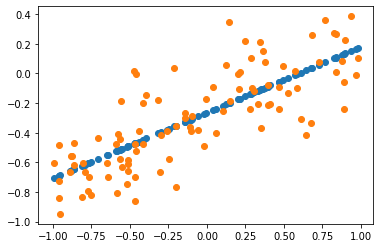

In [13]:
reg.fit(x_,t_)
a0_=reg.coef_
a1_=reg.intercept_
print("parametros", a0_, a1_)
reg.score(x_,t_)
yp=reg.predict(x_)
plt.plot(x,yp,'o')
plt.plot(x,t_,'o')

# Ejercicio 2: Algoritmo de Cuadrados Mínimos para encontrar la mejor base de funciones

El algoritmo de cuadrados mínimos consiste en hallar los parámetros que minimicen la distancia cuadrática entre los datos y mi ajuste $$ E_{D}(\vec{w})=\frac{1}{2}\left(t-\vec{w}^{T}\vec{\phi}(\vec{x})\right)^{2}.$$ Este puede verse como el estimador de máxima verosimilitud cuando modelamos los errores como gaussianos en un problema lineal.

 Considere el siguiente set de datos ``X``y ``T`` como dado:

In [14]:
x=-1.0+2.0*np.random.rand(100)
T=np.asarray(list(map(lambda x: 1.0*np.sin(6*x)+0.0*norm.rvs(loc=0.0,scale=0.1),x)))
T.shape
x.shape
#plt.scatter(x,T)

(100,)

* **A)** Considere la base de funciones los polinomios $\phi_j(x) = x^j$, con $j=1,\dots,M$. Calcule la matriz de diseño.

In [15]:
def matrizdise(x, M):
    """
    Produce la matriz de diseño con features polinomiales de grado M
    
    :param x: vector columna con la variable input
    :type x: np.array of shape (n, 1)
    :param M: grado de las features polinomiales, defaults to 2.
    :type M: int, optional
    :return phi: matriz de diseño con features polinomiales
    :rtype: np.array of shape (n, M+1)
    """  
    # Construye array con los x y los t
    col=[]
    phi0 = np.hstack([x*0.0 + 1])
    for i in range(0,M+1):
        col.append(x**i)

    phi=np.array(col).T 
    
    return phi
#print(matrizdise(x,2))

* **B)** Calcule la solución de cuadrados mínimos, utilizando la expresión dada en el inciso **C)** del **Ejercicio 1**, (la ecuación 3.15 del Bishop; ecuaciones normales). Grafíquela encima de los datos. Estudie como cambia para distintos tamaños de la base, i.e. distintos valores de $M$.

In [16]:
def ajuste_lineal(M, X_train, Y_train, X_test):

    """Calcula un ajuste lineal.

    Input:
    X_train -- datos de entrenamiento, shape=(N,1)
    Y_train -- etiquetas de entrenamiento, shape=(N,1)
    X_test  -- datos de testeo, shape=(N_test,1)

    Output:
    Y_test  -- prediccion de etiquetas para X_test, shape=(N_test,1)
    """

    N=len(X_train)
    N_test=len(X_test)
    #Start
    x = X_train.reshape(len(X_train))
    t = Y_train.reshape(len(Y_train))

    phi = matrizdise(X_train,M)
    pp = np.dot(phi.T, phi)
    yy = np.dot(phi.T, t)

    wml = np.linalg.solve(pp, yy)

    X_test = X_test.reshape(len(X_test))
    phi_test = matrizdise(X_test,M)

    #ahora guardamos los resultados en esta variable
    Y_test = phi_test @ wml
    #Finish
    assert len(Y_test) == len(X_test), "Tamaño de Y_test distinto al de X_test"
    return np.array(Y_test)

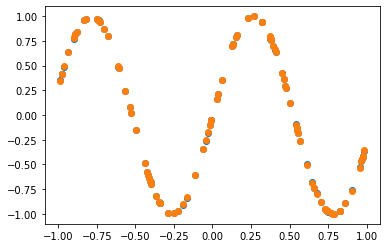

In [17]:
y=ajuste_lineal(9,x,T,x)
plt.scatter(x,T,)
plt.scatter(x,y)

* **C)** Una forma de aproximar la solución cerrada de forma iterativa consiste en aplicar el algoritmo de Descenso por Gradiente para minimizar la función $E_D(\vec{\omega})$:
$$
\vec{w}^{\tau+1}=\vec{w}^{\tau}+\eta\nabla E_{n}(\vec{w}^{\tau})\\
=\vec{w}^{\tau}+\eta(t_{n}-\vec{w}^{\tau T}\vec{\phi}(\vec{x}_n))\vec{\phi}(\vec{x}_{n}).
$$
Donde partimos de un valor $\vec{\omega}^0$ aleatorio que nos permite calcular de forma iterativoa los $\vec{\omega}^\tau$ subsiguientes en función del parametro $\eta$ (también llamado *learning rate*). Examine como se va acercando este algoritmo a la solución cerrada calculada en el inciso anterior, para un valor de $\eta=0.2$. Estudie como varia al cambiar $\eta$ y de $\omega_0$.


* **D)** Se puede ver que incluir un prior normal centrado en cero para los parámetros, equivale a agregar a la función de cuadrados mínimos un término regularizador
$$E_{D}(\vec{w})=\frac{1}{2}\sum_{i=1}^{N}(t_{i}-\vec{w}^{T}\vec{\phi}(\vec{x_{i}}))^{2}+\frac{\kappa}{2}\vec{w}^{T}\vec{w}.$$
Esto se traduce, en el algoritmo recursivo, en la siguiente expresión
$$
\vec{w}^{\tau+1}=\vec{w}^{\tau}+\eta\left[(t_{n}-\vec{w}^{\tau T}\vec{\phi}(\vec{x}_n))\vec{\phi}(\vec{x}_{n}) + \kappa \vec{\omega}^{\tau}\right].
$$
Modifique el código del inciso anterior, y para un valor de $\kappa$ de su elección, estudie que sucede (puede comparar con el caso $\kappa=0$ que coincide con el inciso anterior).

* **E)** Separe el set de datos en training y validation en una proporción de 0.8/0.2. En base a lo visto en la teoría, ¿observa overfitting? ¿a que se debe? ¿cómo lo reduciría? 

# Ejercicio 2 bis: Scikit-learn

Utilizar una base de funciones $\phi_j(x)$ es lo que en la jerga de data science se conoce como *feature extraction*. Transformamos nuestros datos $x$ en features $\tilde x = \phi_j(x)$, los cuales usamos para alimentar nuestros modelos (por ejemplo, el Regresor Lineal de los ejercicios anteriores. Este tipo de transformaciones es parte de lo que se conoce como *pre-procesado* de los datos.

* **A)** Importe de ``sklearn.preprocessing`` la clase ``PolynomialFeatures``. Examine su documentación para ver que es lo que hace.

In [18]:
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing as pp

* **B)** Utilizando ``PolynomialFeatures`` y ``LinearRegressor`` repita el inciso **C** del ejercicio anterior. 

Si le interesa aprender una forma mas elegante de tratar con preprocesado (que podría ser util si se realizan mas transformaciones previas), examine el importe la clase ``Pipeline`` de ``sklearn.pipeline``, e intente usarla con ayuda de [los ejemplos de la documentación](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions).

In [19]:
import numpy.random as rr

ndata = 1000000
ntest = 100000
# 
x = rr.rand(ndata, 1)
xtest = rr.rand(ntest, 1)

# El modelo real (ground truth)
t = np.sin(2*np.pi * x)
ttest = np.sin(2*np.pi * xtest)

# Agregemos error normal a los datos, con desviación standard 0.3
t += rr.randn(ndata, 1) * 0.3
ttest += rr.randn(ntest, 1) * 0.3

# Arrays para representar el modelo verdadero
x_ = np.linspace(0, 1, 100)
t_  = np.sin(2*np.pi * x_)

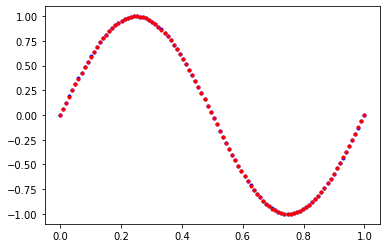

In [20]:
ft=pp.PolynomialFeatures(degree=9)
phi = ft.fit_transform(x)
rl = LinearRegression()
rl.fit(phi, t)

phi_ = ft.fit_transform(x_[:, np.newaxis])
#print(phi_.shape)
ypred_ = rl.predict(phi_)

plt.plot(x_, t_, '.b')
plt.plot(x_, ypred_, '.r')


In [21]:
from sklearn.pipeline import Pipeline

polyregression = Pipeline([('features', pp.PolynomialFeatures(degree=5)),
                          ('regression', LinearRegression())
                          ])

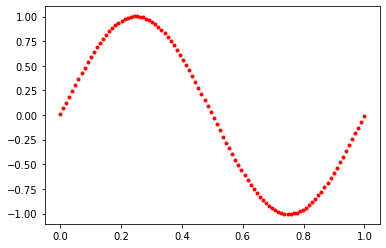

In [23]:
# Ajustemos el modelo a ellos
polyregression.fit(x, t)

# Y calculemos la predicción en un array bien muestreado y en los x de training
y = polyregression.predict(x)
y_ = polyregression.predict(x_[:, np.newaxis] )

# ahora hagamos un plot
#plt.plot(x_, t_, '.b')
plt.plot(x_, y_, '.r')

* **C)** Examine la instancia de ``SGDRegressor``, y usando el argumento ``loss="squared_loss"`` utilicelo para resolver el inciso **D** anterior de forma iterativa (será util el argumento ``learning_rate=constant`` y ``eta0=`` para comparar con la realizada en el ejercicio anterior).

In [128]:
from sklearn.linear_model import SGDRegressor as sgd
SGDRegressor?

In [126]:
clf = sgd(loss='squared_loss', eta0=0.0001, max_iter=10000, learning_rate="adaptive",)
clf.fit(x,t)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0001, fit_intercept=True, l1_ratio=0.15,
             learning_rate='adaptive', loss='squared_loss', max_iter=10000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

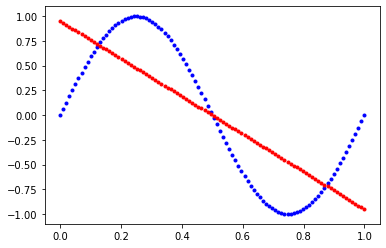

In [127]:
yy = clf.predict(x)
yy_ = clf.predict(x_[:, np.newaxis])

plt.plot(x_, t_, '.b')
plt.plot(x_, yy_, '.r')